In [ ]:
import warnings
warnings.filterwarnings('ignore')

import configparser
cfg = configparser.ConfigParser()
cfg.optionxform = str
cfg.read('/home/sarth/rootdir/datadir/assets/defaults.ini')
cfg = {s: dict(cfg.items(s)) for s in cfg.sections()}
PATHS = cfg['PATHS']

# import torch
# from torch import nn
import numpy as np
import pandas as pd
import xarray as xr
import networkx as nx
import matplotlib.pyplot as plt
import random
import os
import tqdm
import glob
import itertools
import pickle
import gc
import json
# from torch.utils.data import Dataset, DataLoader

RUN_NAME = 'Run02'
PROJECT_DIR = os.path.join('/home/sarth/rootdir/workdir/projects/lumped_analysis_Jun2025')
ANALYSIS_DIR = os.path.join(PROJECT_DIR, 'analysis', RUN_NAME)
RESULTS_DIR = os.path.join(PROJECT_DIR, 'Results', RUN_NAME)

In [ ]:
from scipy import stats, signal

def _mask_valid(pred, true):
    mask = ~np.isnan(true) & ~np.isnan(pred)
    pred = pred[mask]
    true = true[mask]
    pred[pred < 0] = 0
    true[true < 0] = 0
    return pred, true

def RMSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.sqrt(np.mean((true - pred)**2))

def pearsonr(pred, true):
    pred, true = _mask_valid(pred, true)
    r, _ = stats.pearsonr(true, pred)
    return r

def NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return 1 - np.sum((true - pred)**2) / np.sum((true - np.mean(true))**2)

def KGE(pred, true):
    pred, true = _mask_valid(pred, true)
    r = pearsonr(pred, true)
    alpha = np.std(pred) / np.std(true)
    beta = np.mean(pred) / np.mean(true)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def PBIAS(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.sum(true - pred) / np.sum(true) * 100

def alpha_NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.std(pred) / np.std(true)

def beta_NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return (np.mean(pred) - np.mean(true)) / np.std(true)

def _get_fdc(data):
    data = np.sort(data)[::-1]
    return data

def fdc_fms(pred, true, lower = 0.2, upper = 0.7):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)
    sim[sim <= 0] = 1e-6
    obs[obs <= 0] = 1e-6

    qsm_lower = np.log(sim[np.round(lower * len(sim)).astype(int)])
    qsm_upper = np.log(sim[np.round(upper * len(sim)).astype(int)])
    qom_lower = np.log(obs[np.round(lower * len(obs)).astype(int)])
    qom_upper = np.log(obs[np.round(upper * len(obs)).astype(int)])

    fms = ((qsm_lower - qsm_upper) - (qom_lower - qom_upper)) / (qom_lower - qom_upper + 1e-6)

    return fms * 100

def fdc_fhv(pred, true, h = 0.02):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)

    obs = obs[:np.round(h * len(obs)).astype(int)]
    sim = sim[:np.round(h * len(sim)).astype(int)]

    fhv = np.sum(sim - obs) / np.sum(obs)

    return fhv * 100

def fdc_flv(pred, true, l = 0.3):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)
    sim[sim <= 0] = 1e-6
    obs[obs <= 0] = 1e-6

    obs = obs[-np.round(l * len(obs)).astype(int):]
    sim = sim[-np.round(l * len(sim)).astype(int):]

    # transform values to log scale
    obs = np.log(obs)
    sim = np.log(sim)

    # calculate flv part by part
    qsl = np.sum(sim - sim.min())
    qol = np.sum(obs - obs.min())

    flv = -1 * (qsl - qol) / (qol + 1e-6)

    return flv * 100

def mean_peak_timing(pred, true, window = 3):
    pred, true = _mask_valid(pred, true)

    peaks, _ = signal.find_peaks(true, distance=2*window, prominence=np.std(true))

    # pred_idx_lst = []
    timing_error_lst = []
    for idx in peaks:
        if (pred[idx] > pred[idx - 1]) and (pred[idx] > pred[idx + 1]):
            peak_pred = pred[idx]
            peak_pred_idx = idx
        else:
            peak_pred_idx = np.argmax(pred[max(idx - window,0):idx + window + 1]) + max(idx - window,0)
            peak_pred = pred[peak_pred_idx]
        # pred_idx_lst.append(peak_pred_idx)
    
        peak_true = true[idx]
        timing_error = np.abs(peak_pred_idx - idx) 
        timing_error_lst.append(timing_error)
    
    mean_timing_error = np.mean(timing_error_lst) if len(timing_error_lst) > 0 else np.nan

    return mean_timing_error

def missed_peaks(pred, true, window = 3, threshold = 80):
    pred, true = _mask_valid(pred, true)

    peaks_obs_times, _ = signal.find_peaks(true, distance=2*window, height = np.percentile(true, threshold))
    peaks_sim_times, _ = signal.find_peaks(pred, distance=2*window, height = np.percentile(pred, threshold))
    
    missed_events = 0
    for idx in peaks_obs_times:
        nearby_peak_sim_index = np.where(np.abs(peaks_sim_times - idx) <= window)[0]
        if len(nearby_peak_sim_index) == 0:
            missed_events += 1
            # print(idx)
    
    missed_peak_values = (missed_events / len(peaks_obs_times)) * 100 if len(peaks_obs_times) > 0 else np.nan

    return missed_peak_values

def F1_score_of_capturing_peaks(pred, true, window = 3, threshold = 80):
    pred, true = _mask_valid(pred, true)

    peaks_obs_times, _ = signal.find_peaks(true, distance=2*window, height = np.percentile(true, threshold))
    peaks_sim_times, _ = signal.find_peaks(pred, distance=2*window, height = np.percentile(pred, threshold))
    
    true_positive_peaks = 0 # peak in obs and nearby in sim
    true_negative_peaks = 0 # no peak in obs and sim
    false_positive_peaks = 0 # peak in sim but not nearby in obs
    false_negative_peaks = 0 # peak in obs but not nearby in sim

    for idx in peaks_obs_times:
        nearby_peak_sim_index = np.where(np.abs(peaks_sim_times - idx) <= window)[0]
        if len(nearby_peak_sim_index) > 0:
            true_positive_peaks += 1
        else:
            false_negative_peaks += 1
    
    for idx in peaks_sim_times:
        nearby_peak_obs_index = np.where(np.abs(peaks_obs_times - idx) <= window)[0]
        if len(nearby_peak_obs_index) == 0:
            false_positive_peaks += 1

    precision = true_positive_peaks / (true_positive_peaks + false_positive_peaks) if (true_positive_peaks + false_positive_peaks) > 0 else np.nan
    recall = true_positive_peaks / (true_positive_peaks + false_negative_peaks) if (true_positive_peaks + false_negative_peaks) > 0 else np.nan
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else np.nan

    return f1_score

In [ ]:
import numpy as np
import xarray as xr

def compute_metrics_ds(y_pred, y_true):
    """
    Compute a set of metrics for each lead time and catchment.
    y_pred and y_true: numpy arrays of shape (time_idx, lead_time, catmt_idx)
    
    Returns:
      xr.Dataset with dims ("time_idx", "lead_time", "catmt_idx") and variables:
          - RMSE, PearsonR, NSE, KGE, PBIAS, alpha_NSE, beta_NSE,
            FDC_FMS, FDC_FHV, FDC_FLV, mean_peak_timing, missed_peaks, F1_score
          - Also includes raw y_pred and y_true.
    """

    time_steps, num_leadtimes, num_catmt = y_pred.shape

    # Prepare arrays to hold computed metrics [lead_time, catmt_idx]
    rmse_arr            = np.empty((num_leadtimes, num_catmt))
    pearson_arr         = np.empty((num_leadtimes, num_catmt))
    nse_arr             = np.empty((num_leadtimes, num_catmt))
    kge_arr             = np.empty((num_leadtimes, num_catmt))
    pbias_arr           = np.empty((num_leadtimes, num_catmt))
    alpha_nse_arr       = np.empty((num_leadtimes, num_catmt))
    beta_nse_arr        = np.empty((num_leadtimes, num_catmt))
    fdc_fms_arr         = np.empty((num_leadtimes, num_catmt))
    fdc_fhv_arr         = np.empty((num_leadtimes, num_catmt))
    fdc_flv_arr         = np.empty((num_leadtimes, num_catmt))
    mean_peak_timing_arr= np.empty((num_leadtimes, num_catmt))
    missed_peaks_arr    = np.empty((num_leadtimes, num_catmt))
    f1_score_arr        = np.empty((num_leadtimes, num_catmt))

    # Loop over lead times and catchments, computing metrics from the time series
    for lt in range(num_leadtimes):
        for cat in range(num_catmt):
            pred = y_pred[:, lt, cat]
            true = y_true[:, lt, cat]
            rmse_arr[lt, cat]             = RMSE(pred, true)
            pearson_arr[lt, cat]          = pearsonr(pred, true)
            nse_arr[lt, cat]              = NSE(pred, true)
            kge_arr[lt, cat]              = KGE(pred, true)
            pbias_arr[lt, cat]            = PBIAS(pred, true)
            alpha_nse_arr[lt, cat]        = alpha_NSE(pred, true)
            beta_nse_arr[lt, cat]         = beta_NSE(pred, true)
            fdc_fms_arr[lt, cat]          = fdc_fms(pred, true)
            fdc_fhv_arr[lt, cat]          = fdc_fhv(pred, true)
            fdc_flv_arr[lt, cat]          = fdc_flv(pred, true)
            mean_peak_timing_arr[lt, cat] = mean_peak_timing(pred, true)
            missed_peaks_arr[lt, cat]     = missed_peaks(pred, true)
            f1_score_arr[lt, cat]         = F1_score_of_capturing_peaks(pred, true)

    # Create coordinates
    lead_times = np.arange(num_leadtimes)
    catmt_idx  = np.arange(num_catmt)
    time_idx   = np.arange(time_steps)

    ds = xr.Dataset(
        {
            "RMSE":             (("lead_time", "catmt_idx"), rmse_arr), # SI
            "PearsonR":         (("lead_time", "catmt_idx"), pearson_arr), # SI
            "NSE":              (("lead_time", "catmt_idx"), nse_arr), # Main
            "KGE":              (("lead_time", "catmt_idx"), kge_arr), # SI
            "PBIAS":            (("lead_time", "catmt_idx"), pbias_arr), # SI
            "alpha_NSE":        (("lead_time", "catmt_idx"), alpha_nse_arr),
            "beta_NSE":         (("lead_time", "catmt_idx"), beta_nse_arr),
            "FDC_FMS":          (("lead_time", "catmt_idx"), fdc_fms_arr),
            "FDC_FHV":          (("lead_time", "catmt_idx"), fdc_fhv_arr), # SI
            "FDC_FLV":          (("lead_time", "catmt_idx"), fdc_flv_arr), # SI
            "mean_peak_timing": (("lead_time", "catmt_idx"), mean_peak_timing_arr), # SI
            "missed_peaks":     (("lead_time", "catmt_idx"), missed_peaks_arr), # SI
            "F1_score":         (("lead_time", "catmt_idx"), f1_score_arr), # Main
            "y_pred":           (("time_idx", "lead_time", "catmt_idx"), y_pred),
            "y_true":           (("time_idx", "lead_time", "catmt_idx"), y_true)
        },
        coords={
            "time_idx": time_idx,
            "lead_time": lead_times,
            "catmt_idx": catmt_idx
        }
    )
    
    return ds

# # Example usage:
# metrics_ds = compute_metrics_ds(y_pred, y_true)
# metrics_ds

In [ ]:
suffix = 'pred_glofas' # 'pred_gauge' or 'glofas_gauge' or 'pred_glofas'
varname = 'NSE'
lead_time = 1
min_max = None
HUCs = [str(i).zfill(2) for i in range(1, 18+1)]

In [ ]:
from matplotlib import category
import numpy as np
import os
import xarray as xr

import matplotlib.pyplot as plt

In [ ]:
metrics_dict = {}
for model_huc in tqdm.tqdm(HUCs):
    metrics_dict[model_huc] = {}
    for prediction_huc in HUCs:
        y_true = np.load(os.path.join(ANALYSIS_DIR, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', 'y_ground_truth.npy'))
        y_pred = np.load(os.path.join(ANALYSIS_DIR, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', 'y_predictions.npy'))
        y_true = y_true[:, :1, :]
        y_pred = y_pred[:, :1, :]
        metrics = compute_metrics_ds(y_pred, y_true)
        metrics_dict[model_huc][prediction_huc] = metrics


In [ ]:
metrics_dict['05']['05']

In [47]:
def plot_heatmap(varname, suffix = 'pred_glofas', lead_time = 1, min_max = None, cmap = 'coolwarm_r', extend = 'both', varlabel = None):
    HUCs = [str(i).zfill(2) for i in range(1, 18+1)]

    fontsize_tick = 12
    fontsize_label = 16

    if varlabel is None:
        varlabel = varname

    df = pd.DataFrame(index=HUCs, columns=HUCs)

    for model_huc in HUCs:
        metric_values = []
        for prediction_huc in HUCs:
            metrics = metrics_dict[model_huc][prediction_huc]
            metrics = metrics[varname].sel(lead_time=lead_time).values
            metrics = np.nanmedian(metrics)
            metric_values.append(metrics)
        df[model_huc] = metric_values

    df.index.name = 'Model HUC'
    df.columns.name = 'Prediction HUC'

    # # Clip values below -10
    # df = df.clip(lower=-10)

    # Set values below -10 to NaN
    # df[df < -1] = np.nan

    cmap = plt.cm.get_cmap(cmap).copy()
    # cmap.set_bad(color='black')

    plt.figure(figsize=(10, 8), dpi = 300)
    if min_max is not None:
        plt.pcolor(df, cmap=cmap, edgecolors='k', linewidths=0.5, vmin = min_max[0], vmax = min_max[1])
    else:
        plt.pcolor(df, cmap=cmap, edgecolors='k', linewidths=0.5)
    if extend is not None:
        cbar = plt.colorbar(extend=extend)
    else:
        cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=fontsize_tick, rotation=0)
    cbar.set_label(varlabel, fontsize=fontsize_label)
    plt.xticks(ticks=np.arange(len(HUCs)) + 0.5, labels=HUCs, rotation=45, fontsize=fontsize_tick)
    plt.yticks(ticks=np.arange(len(HUCs)) + 0.5, labels=HUCs, fontsize=fontsize_tick)
    # plt.title(f'{varname} Heatmap for Lead Time {lead_time}')
    plt.tight_layout()
    plt.xlabel('Prediction HUC', fontsize=fontsize_label)
    plt.ylabel('Model HUC', fontsize=fontsize_label)
    plt.show()

    return df

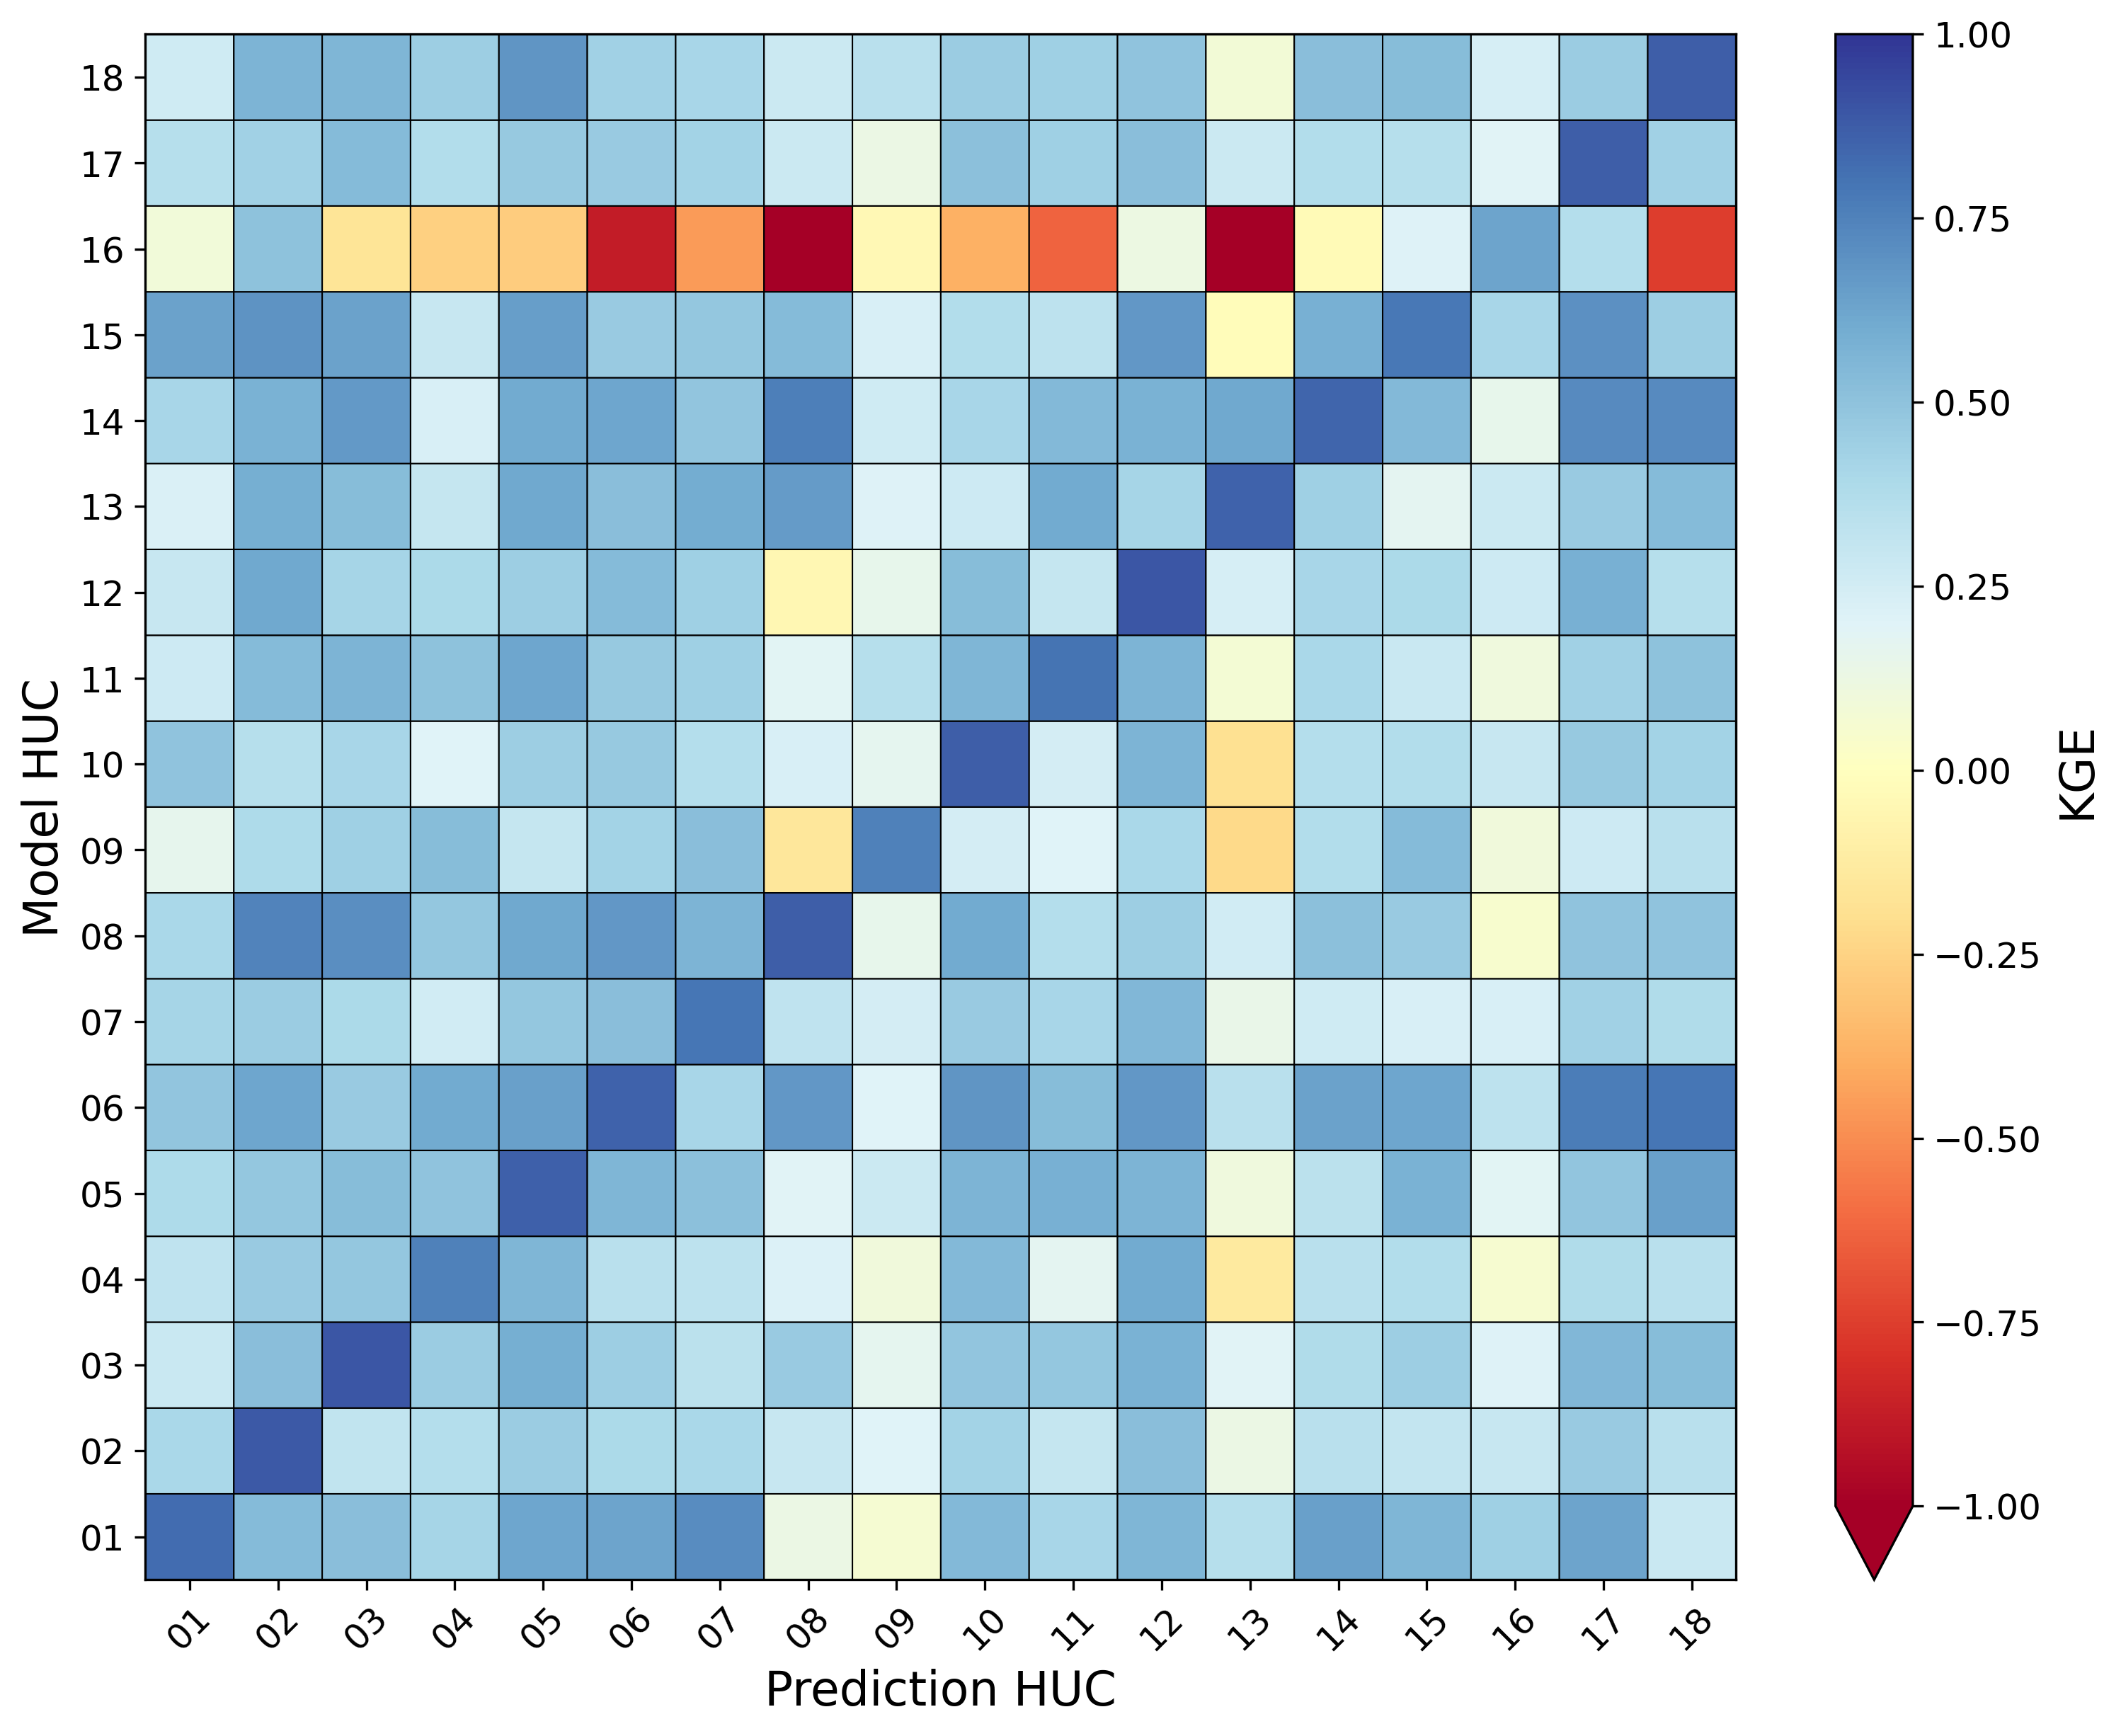

In [48]:
_ = plot_heatmap('KGE', suffix='pred_glofas', lead_time=0, cmap = 'RdYlBu', min_max = [-1, 1], extend = 'min', varlabel = 'KGE')

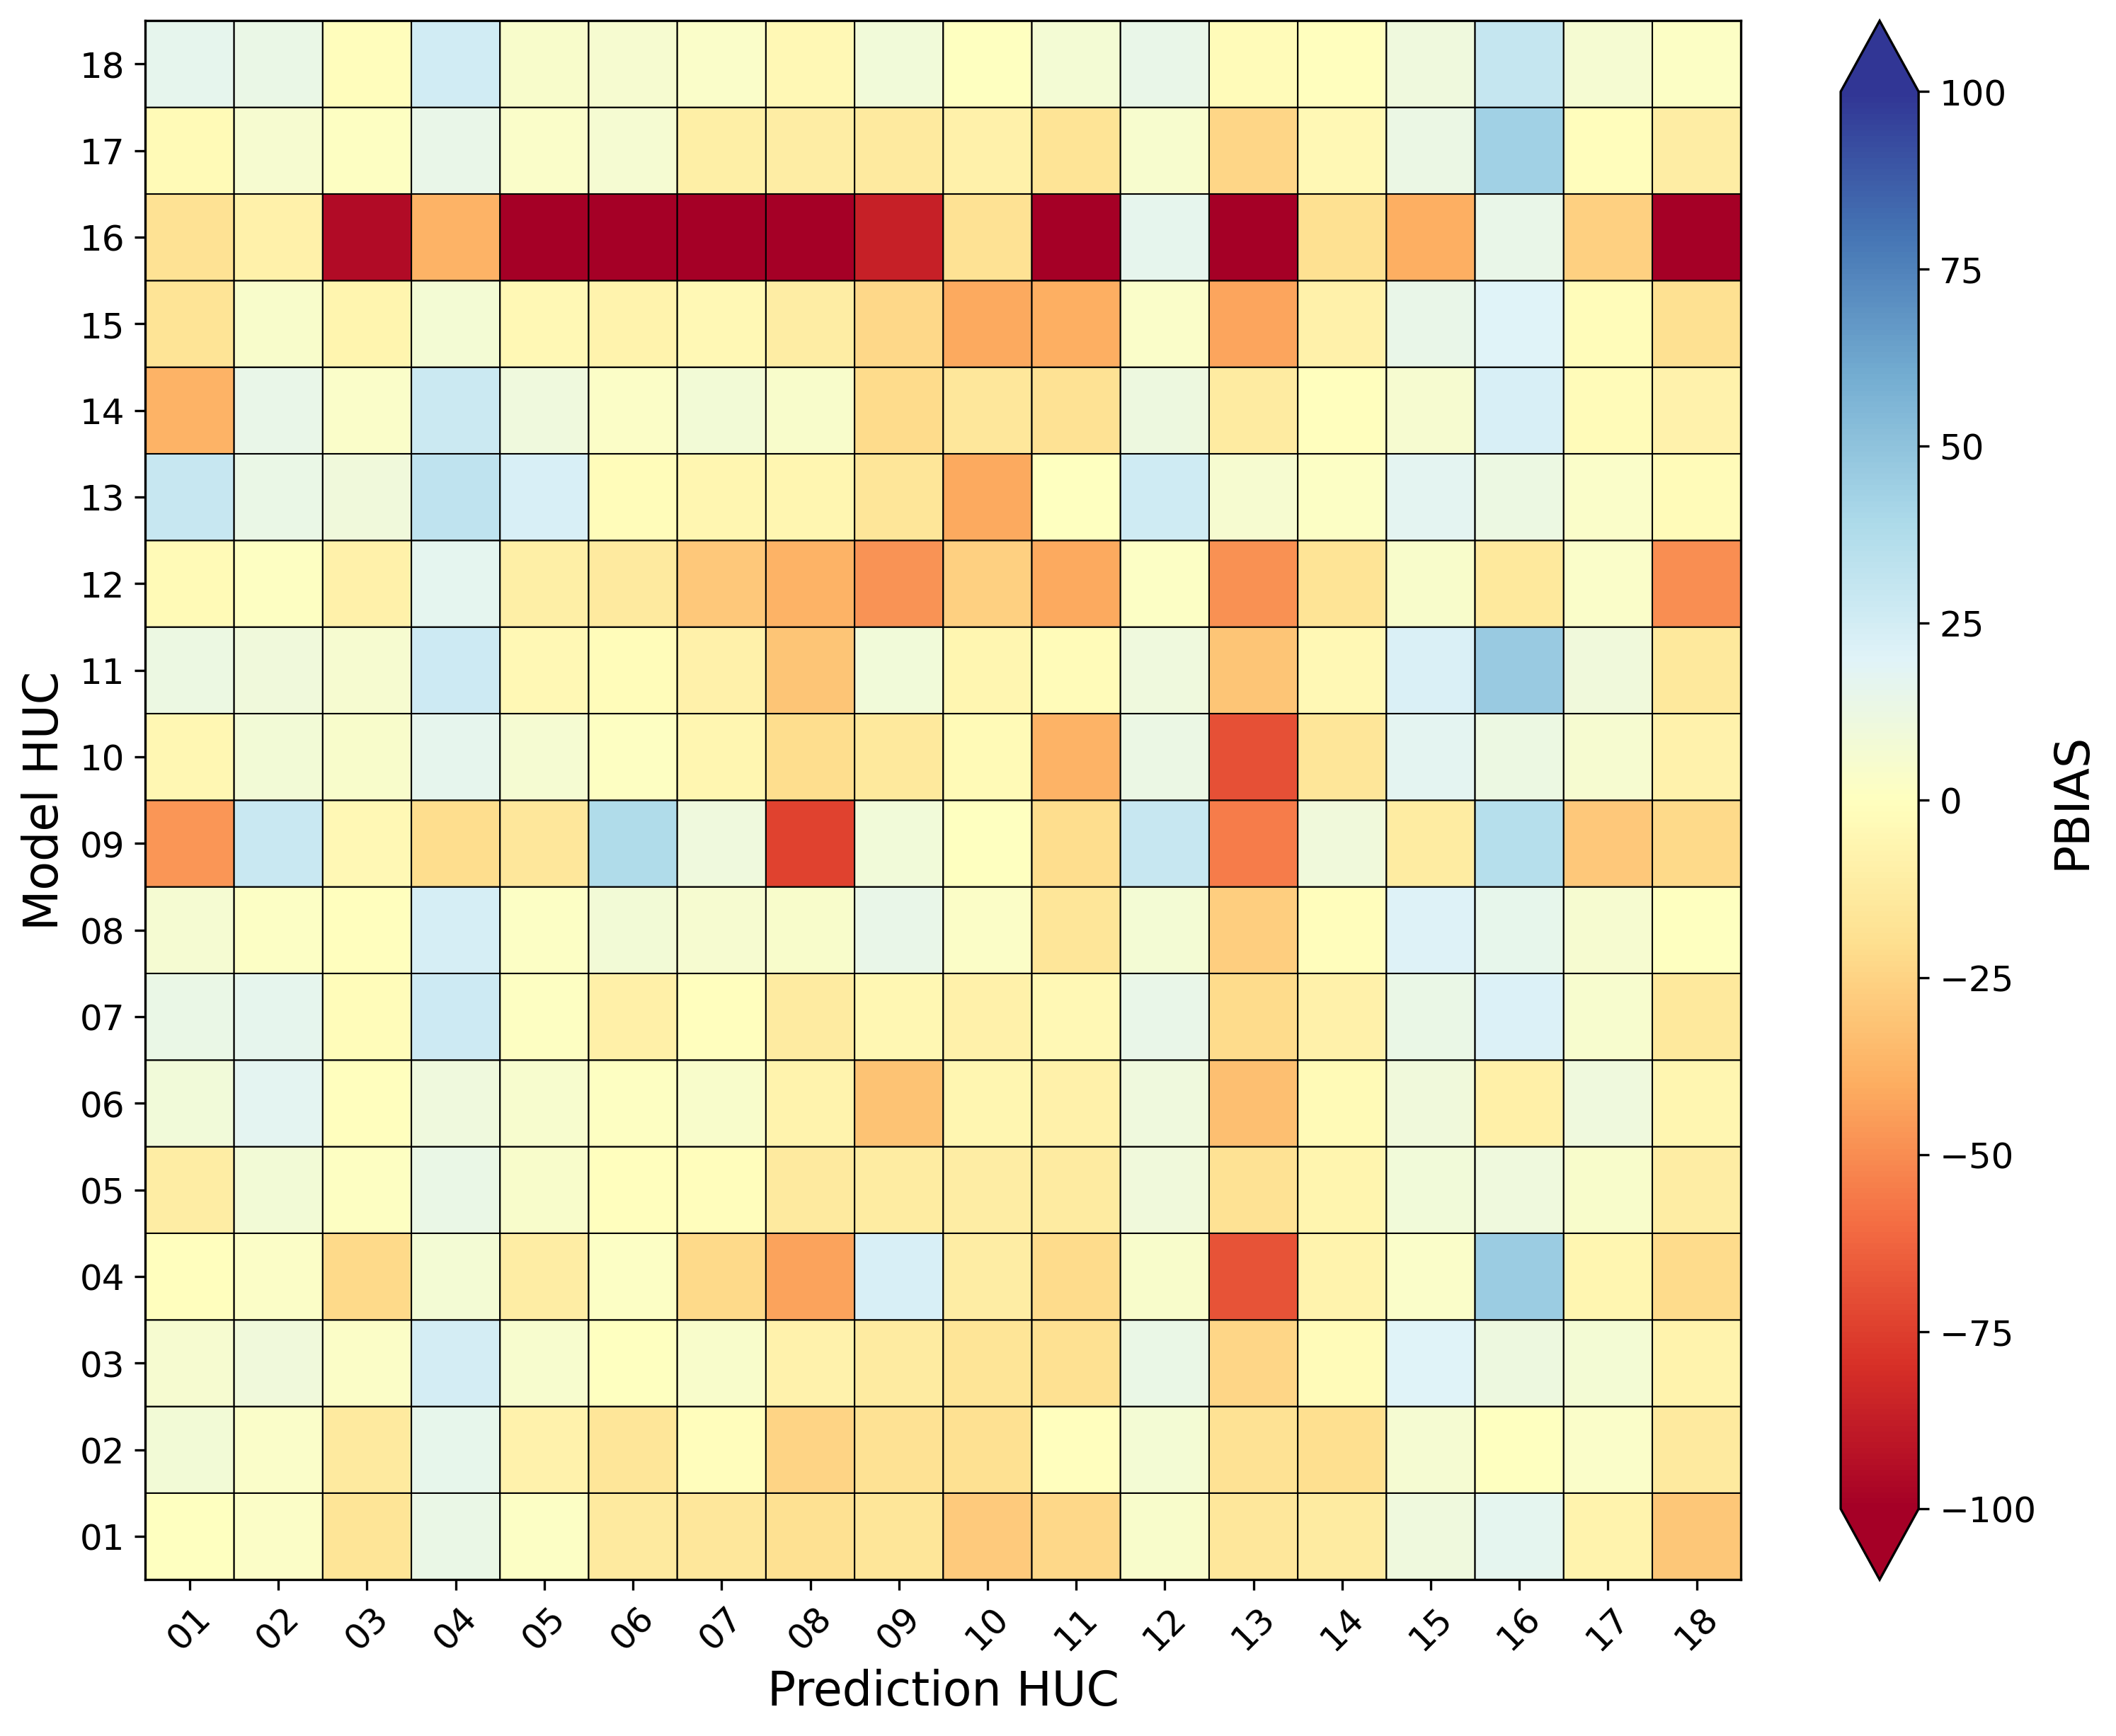

In [49]:
_ = plot_heatmap('PBIAS', suffix='pred_glofas', lead_time=0, cmap = 'RdYlBu', min_max = [-100, 100], extend = 'both', varlabel = 'PBIAS')

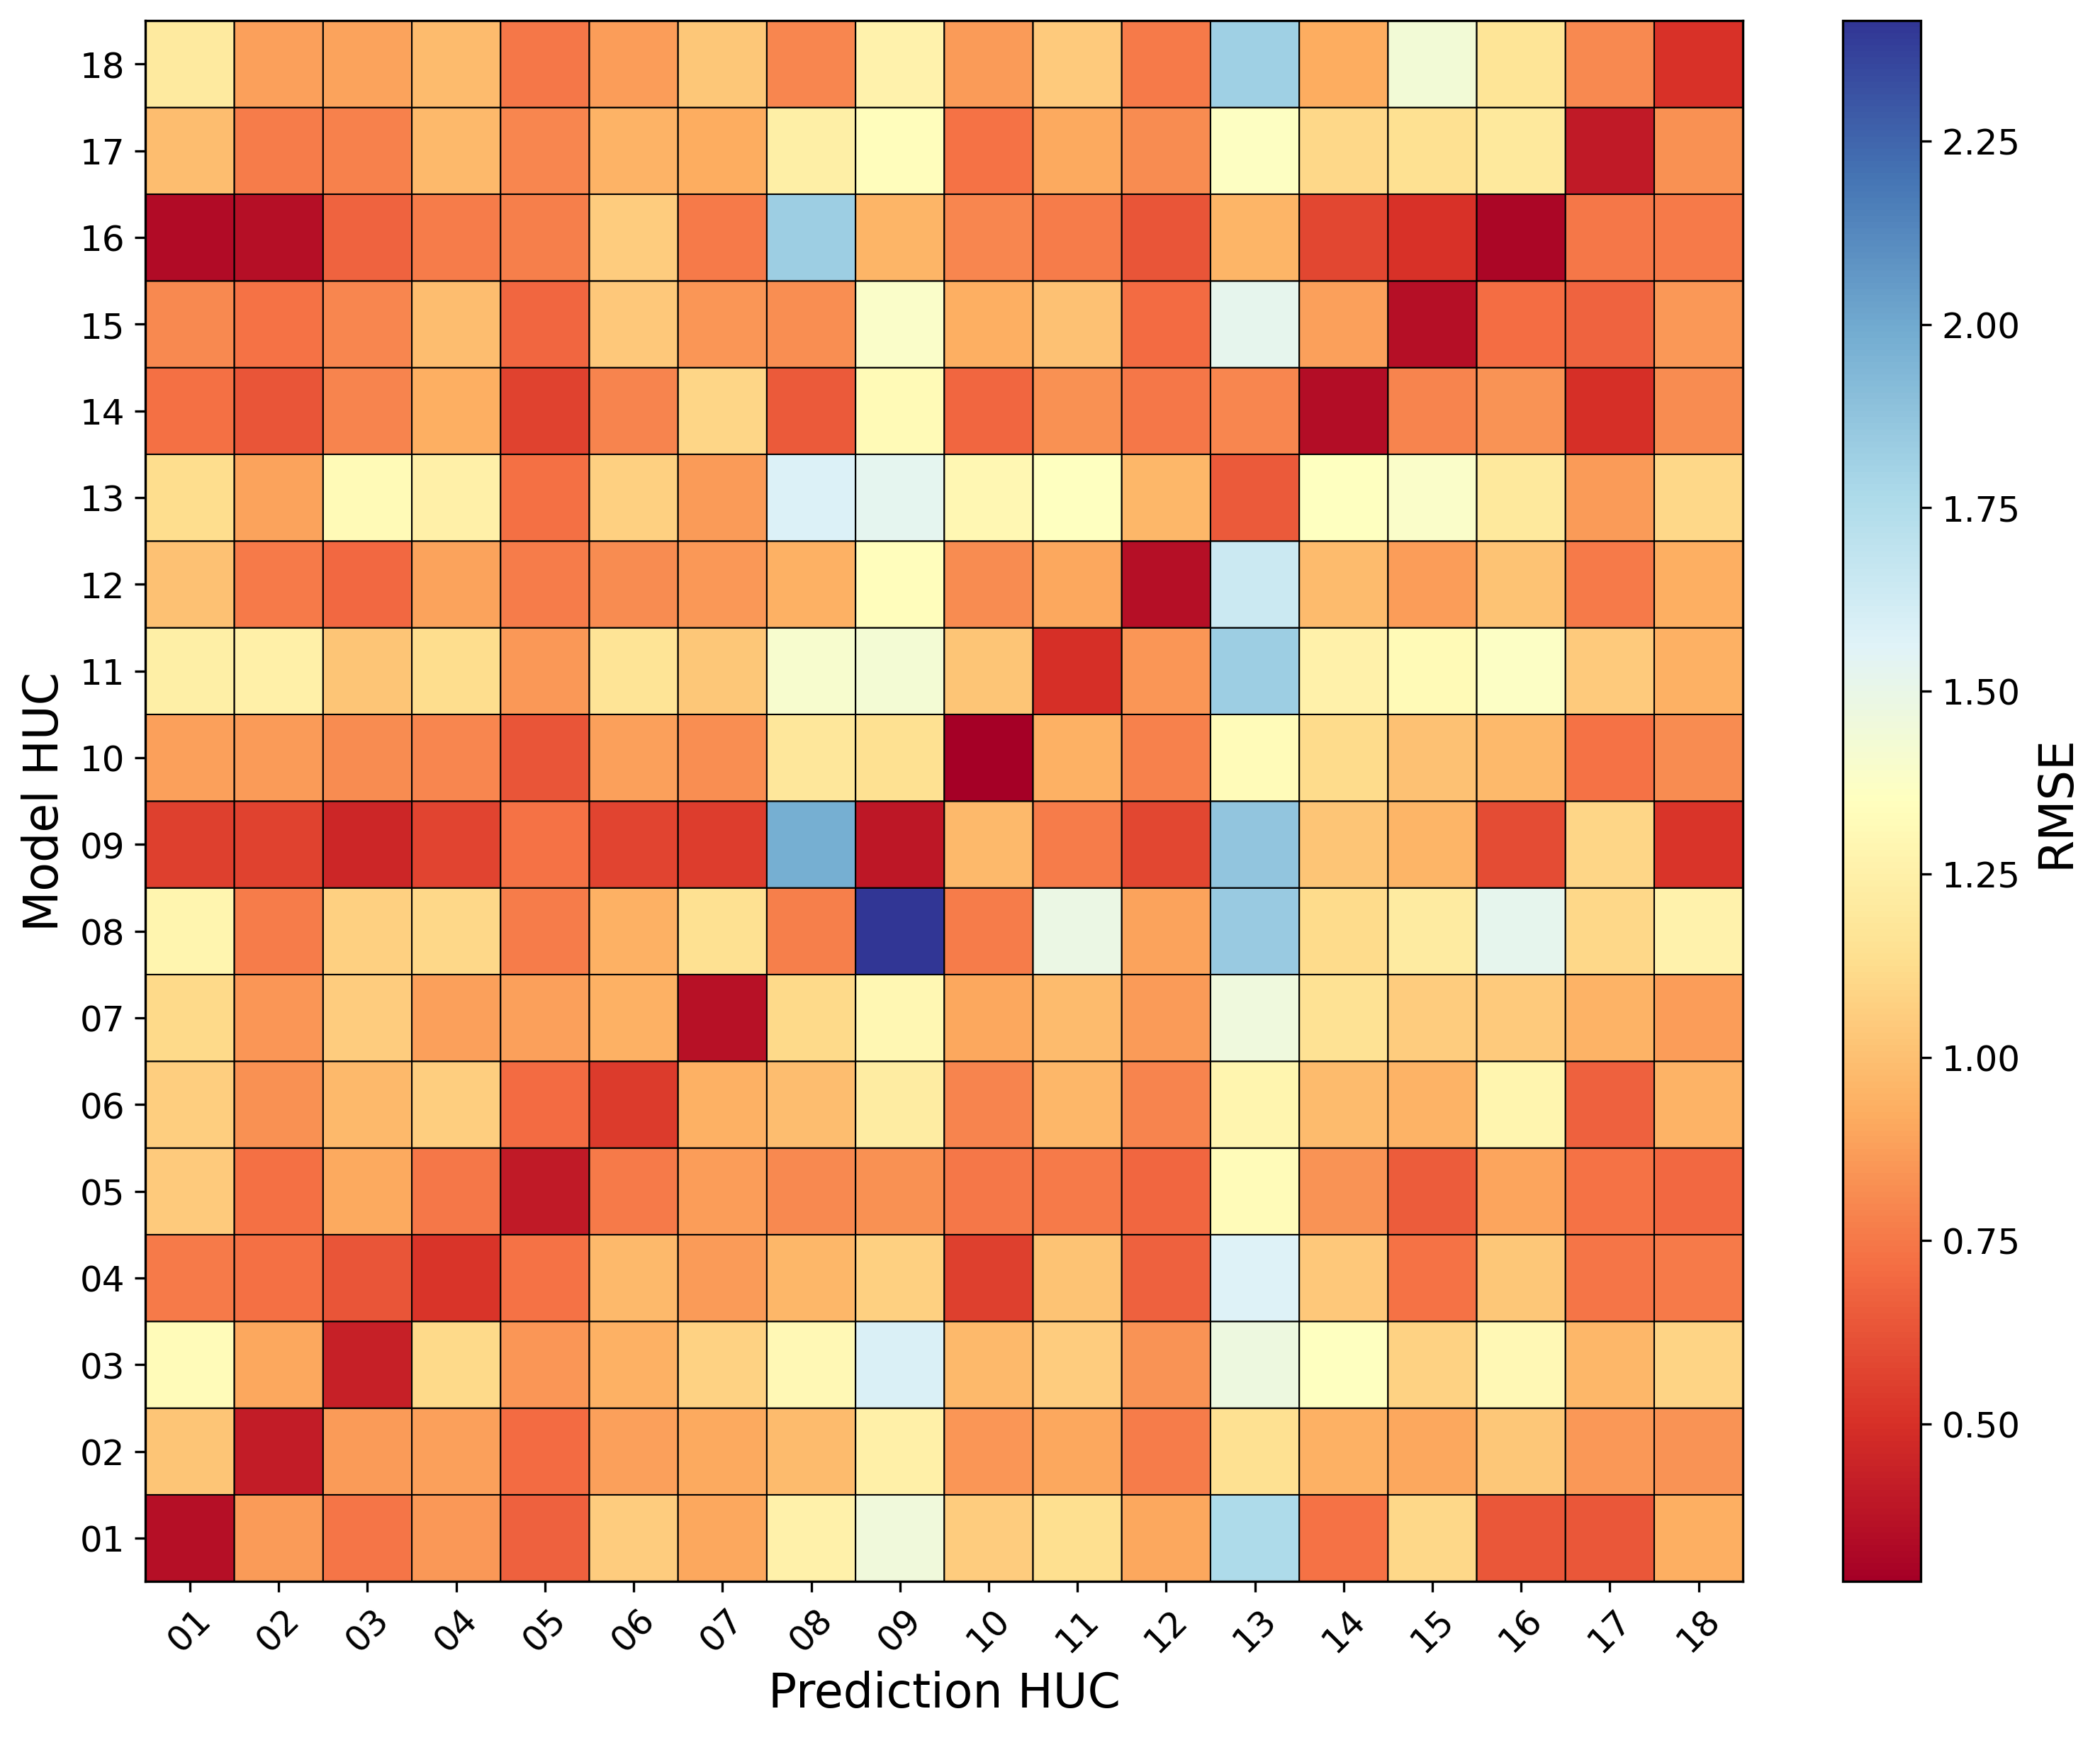

In [50]:
_ = plot_heatmap('RMSE', suffix='pred_glofas', lead_time=0, cmap = 'RdYlBu', min_max = None, extend = None, varlabel = 'RMSE')

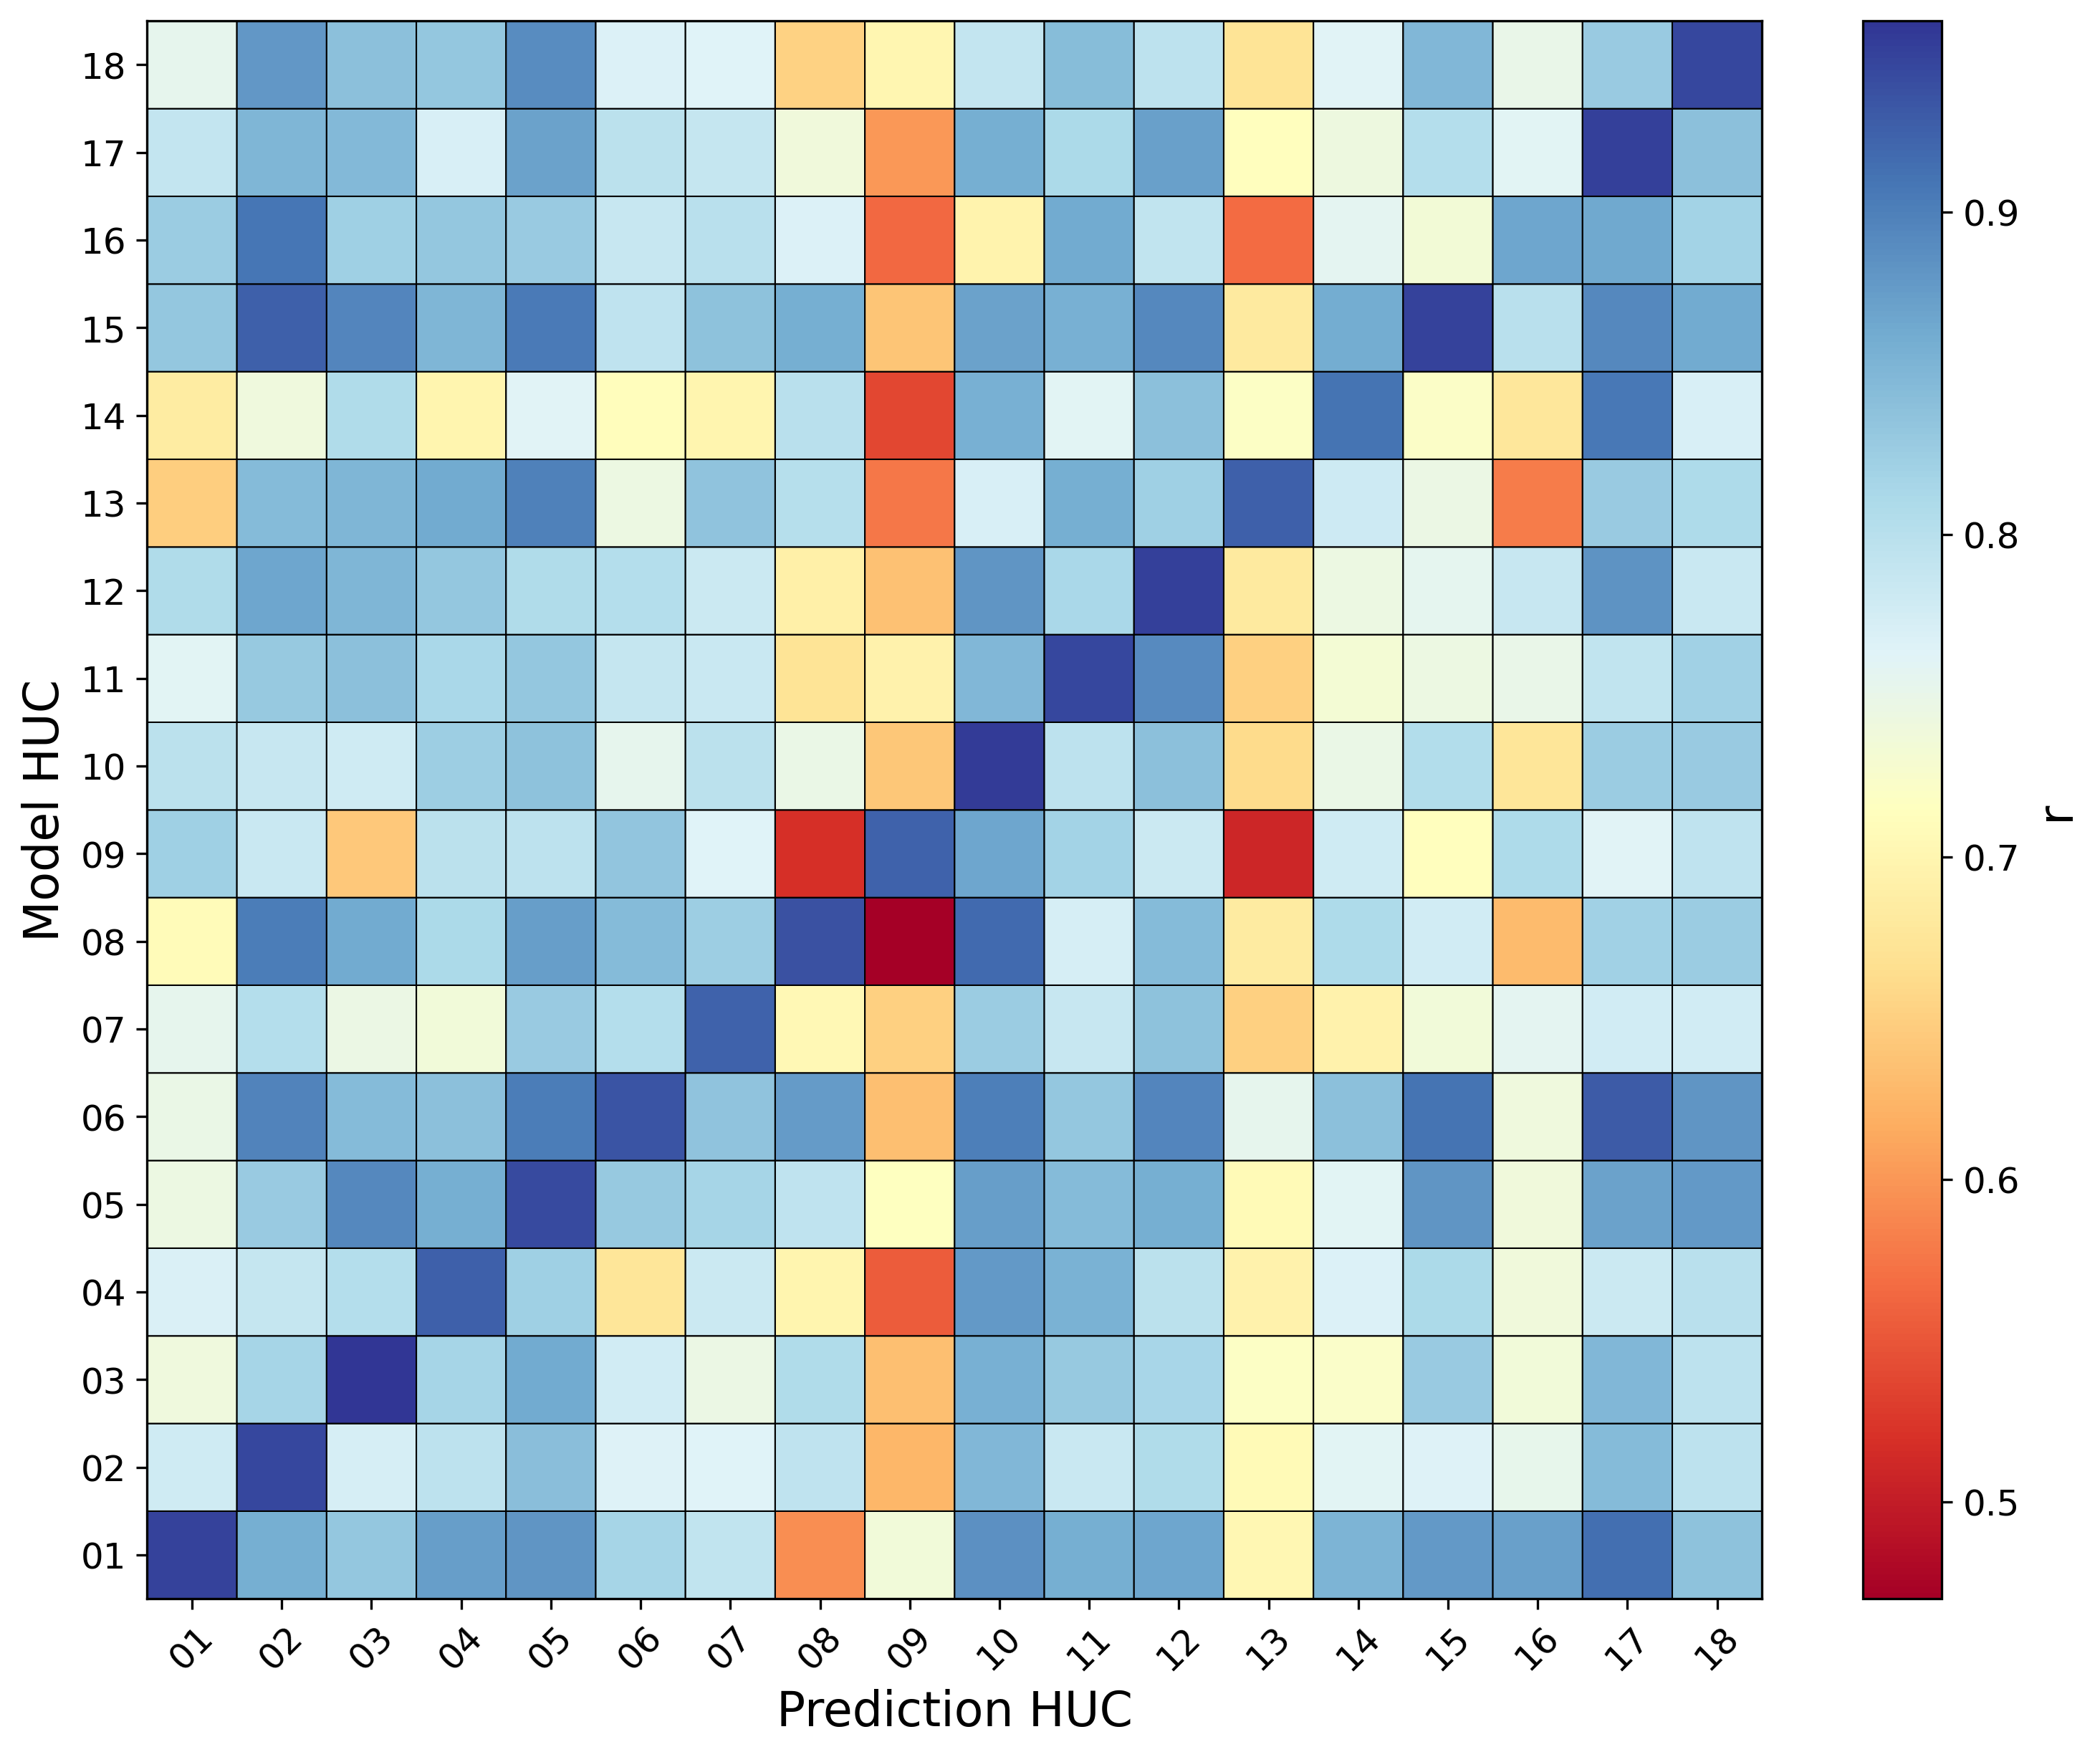

In [51]:
_ = plot_heatmap('PearsonR', suffix='pred_glofas', lead_time=0, cmap = 'RdYlBu', min_max = None, extend = None, varlabel = 'r')

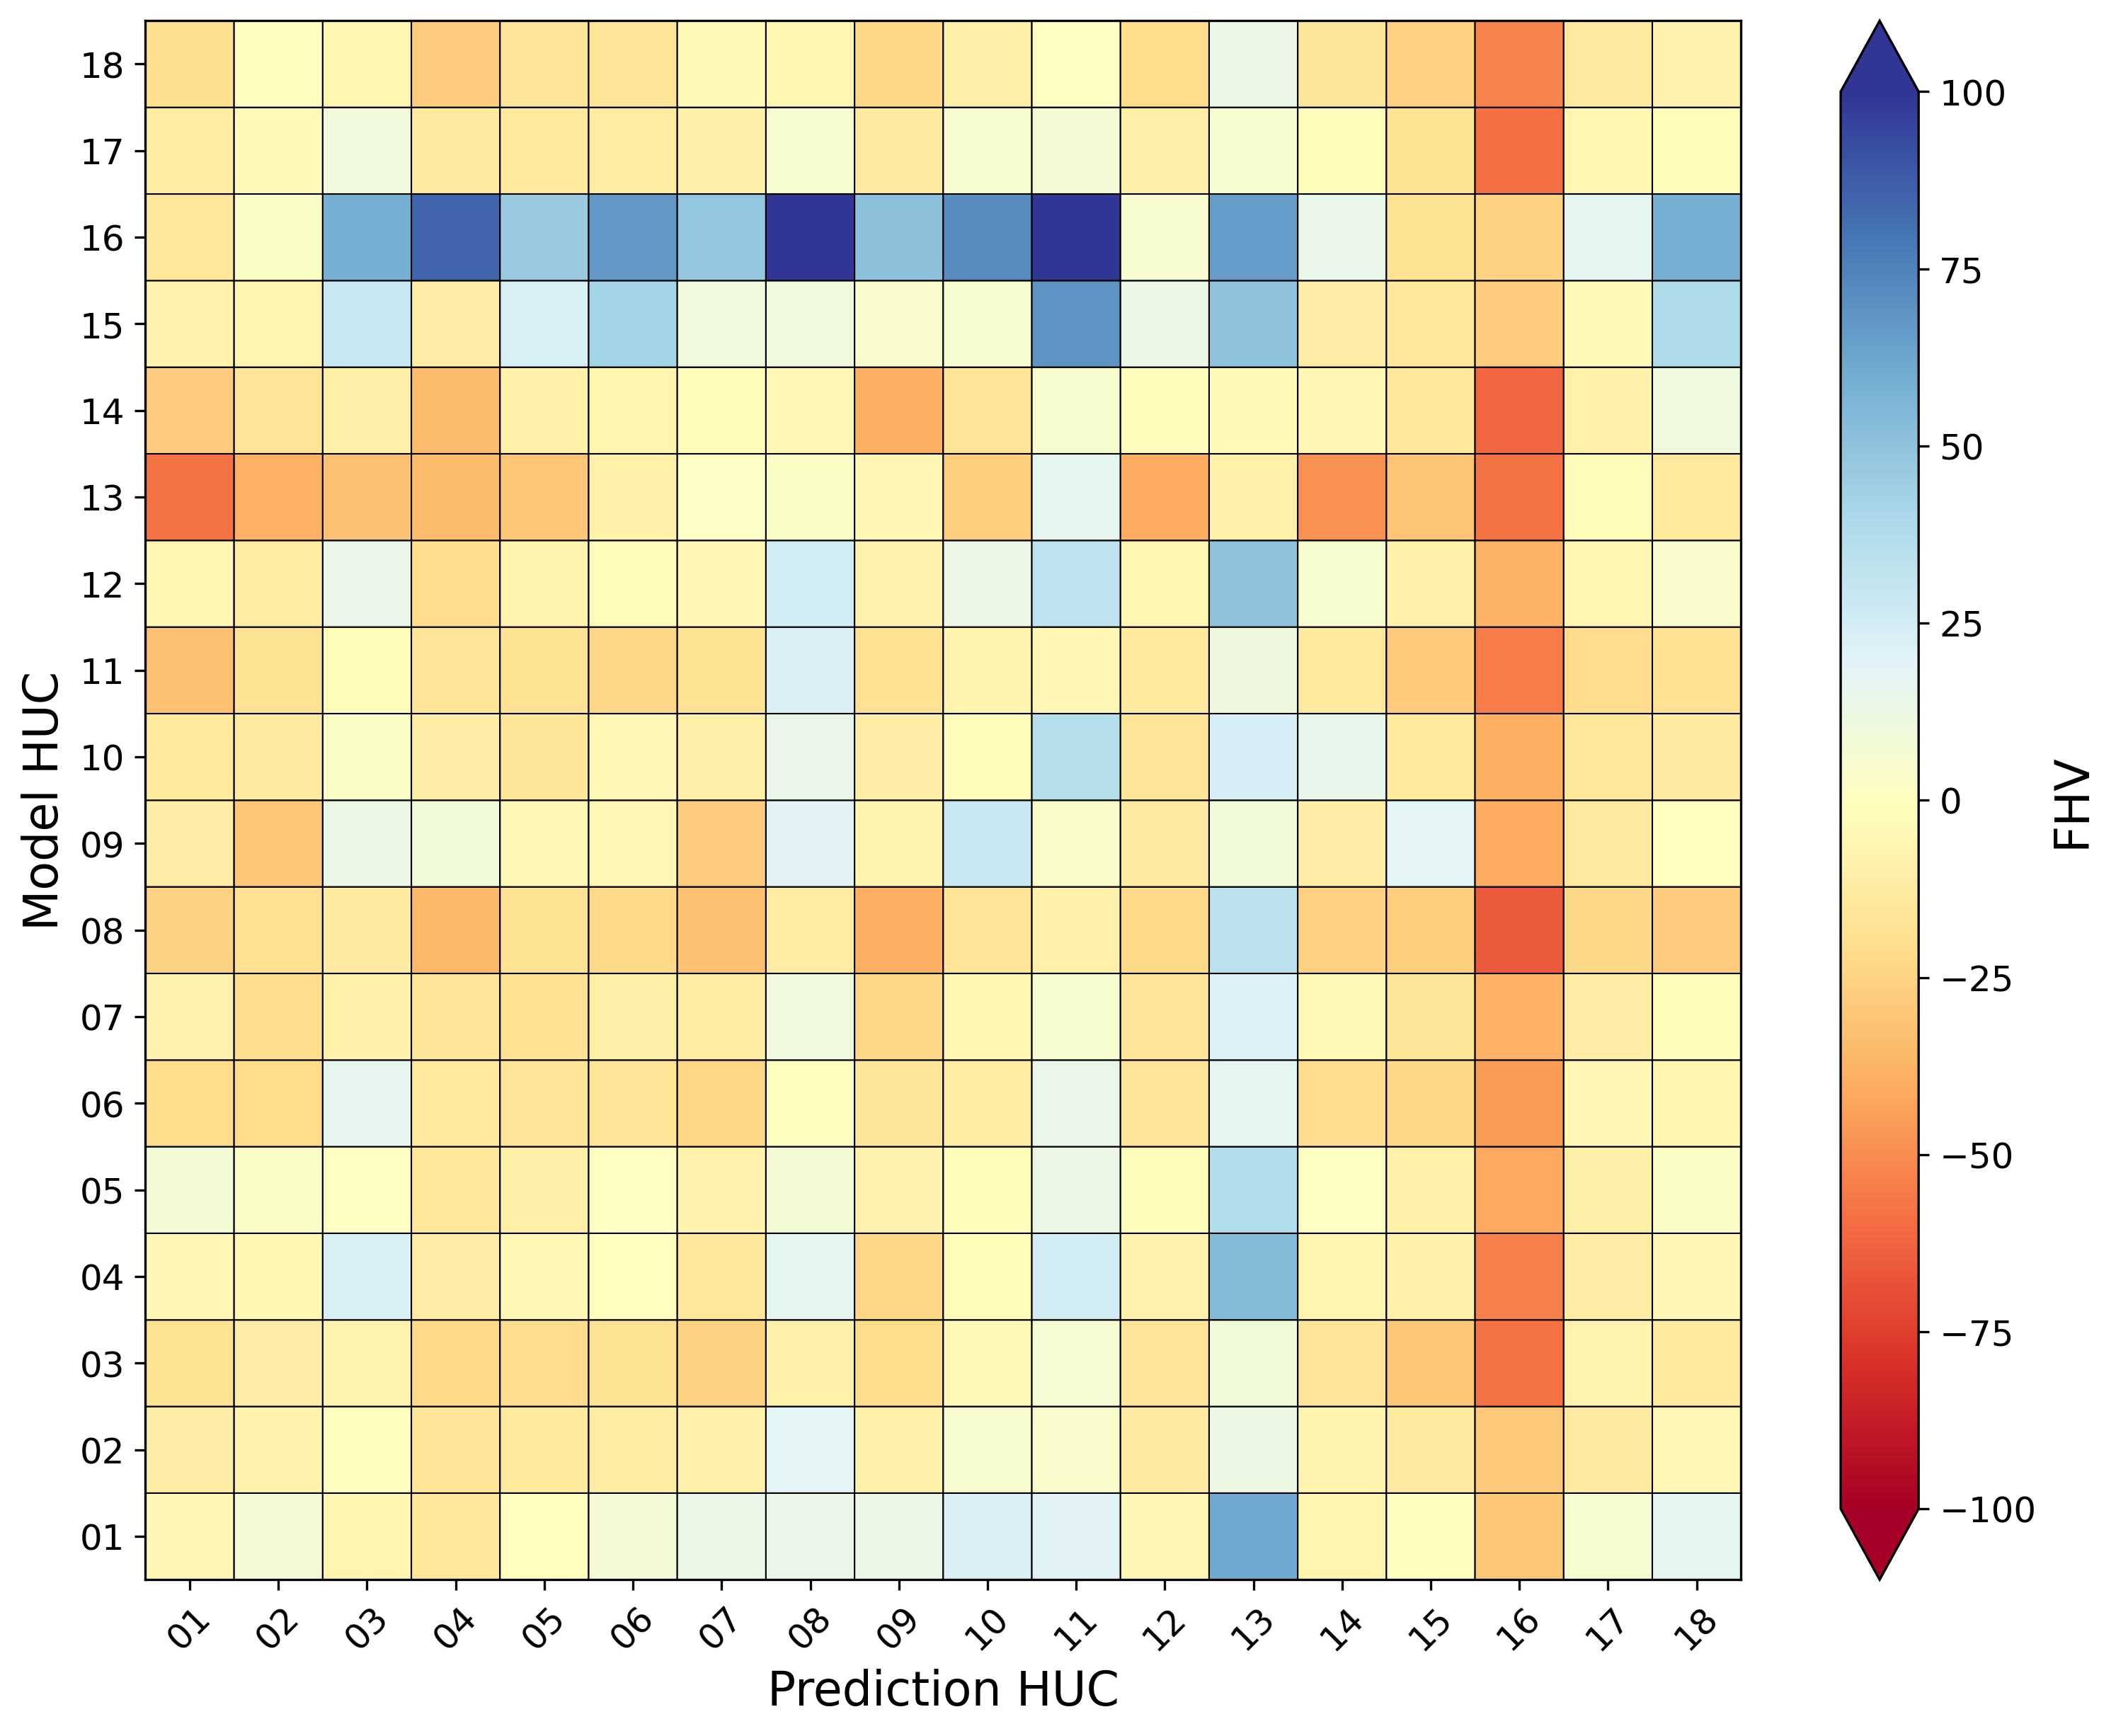

In [52]:
_ = plot_heatmap('FDC_FHV', suffix='pred_glofas', lead_time=0, cmap = 'RdYlBu', min_max = [-100, 100], extend = 'both', varlabel = 'FHV')

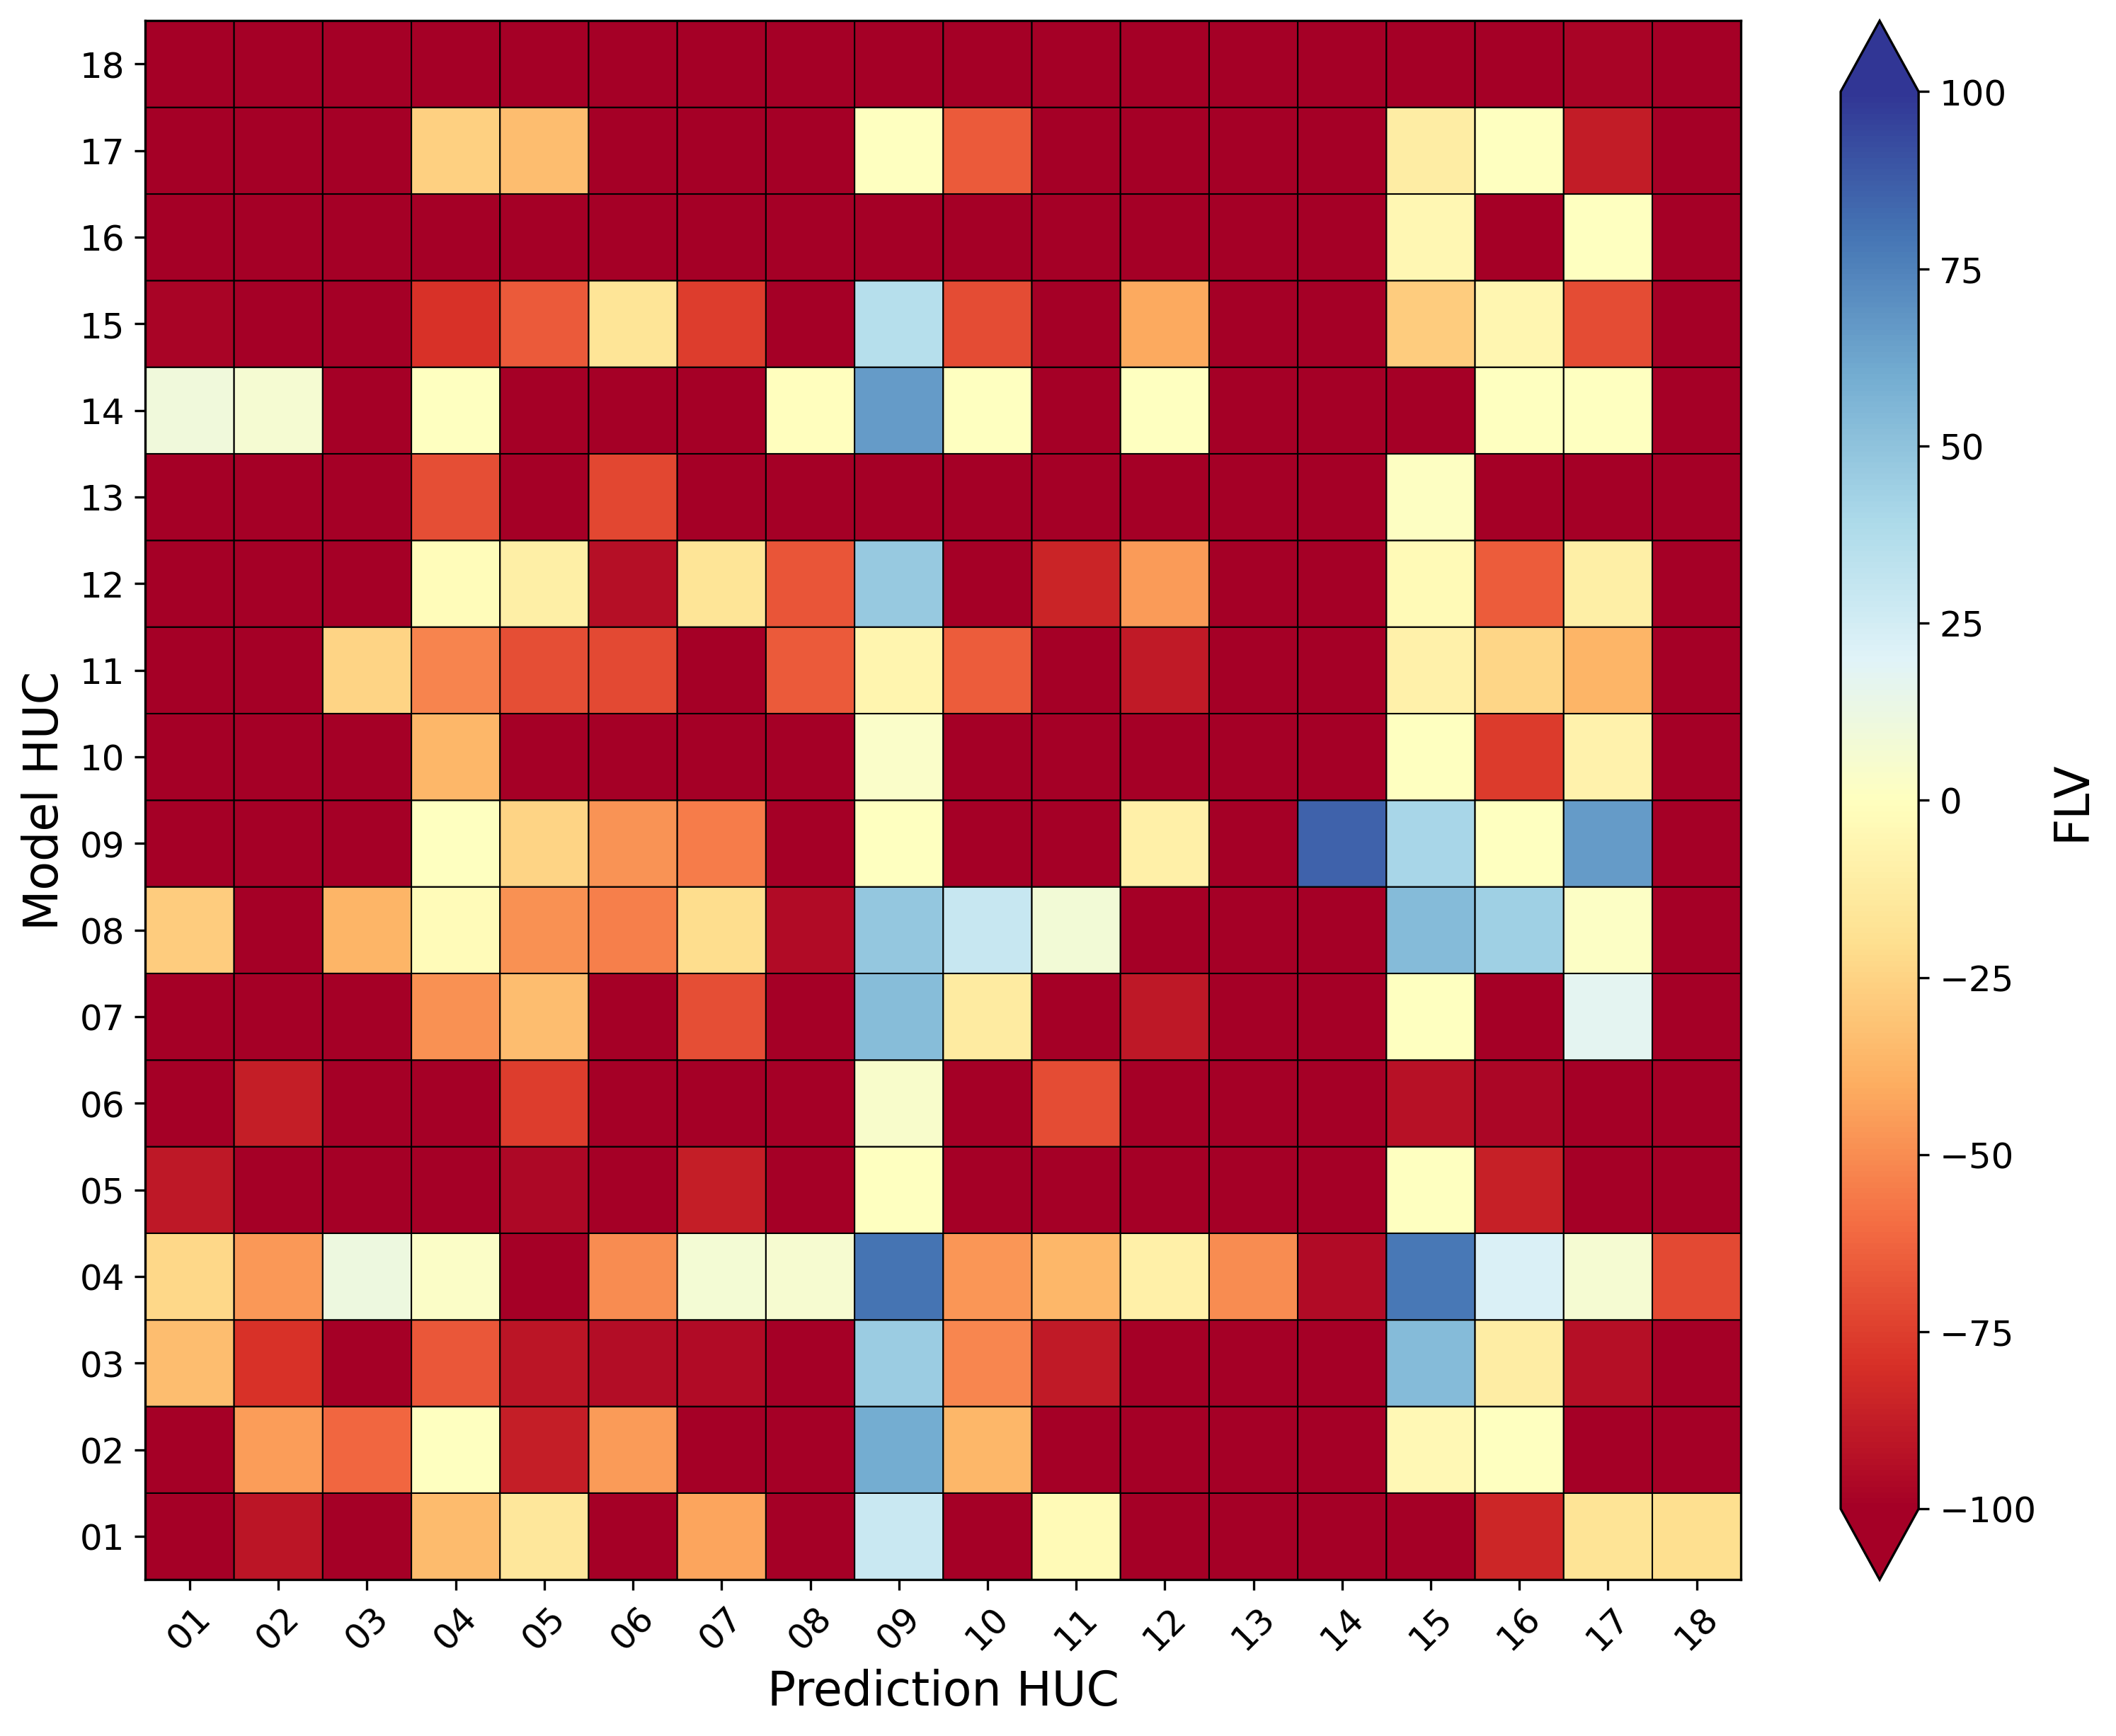

In [53]:
_ = plot_heatmap('FDC_FLV', suffix='pred_glofas', lead_time=0, cmap = 'RdYlBu', min_max = [-100, 100], extend = 'both', varlabel = 'FLV')

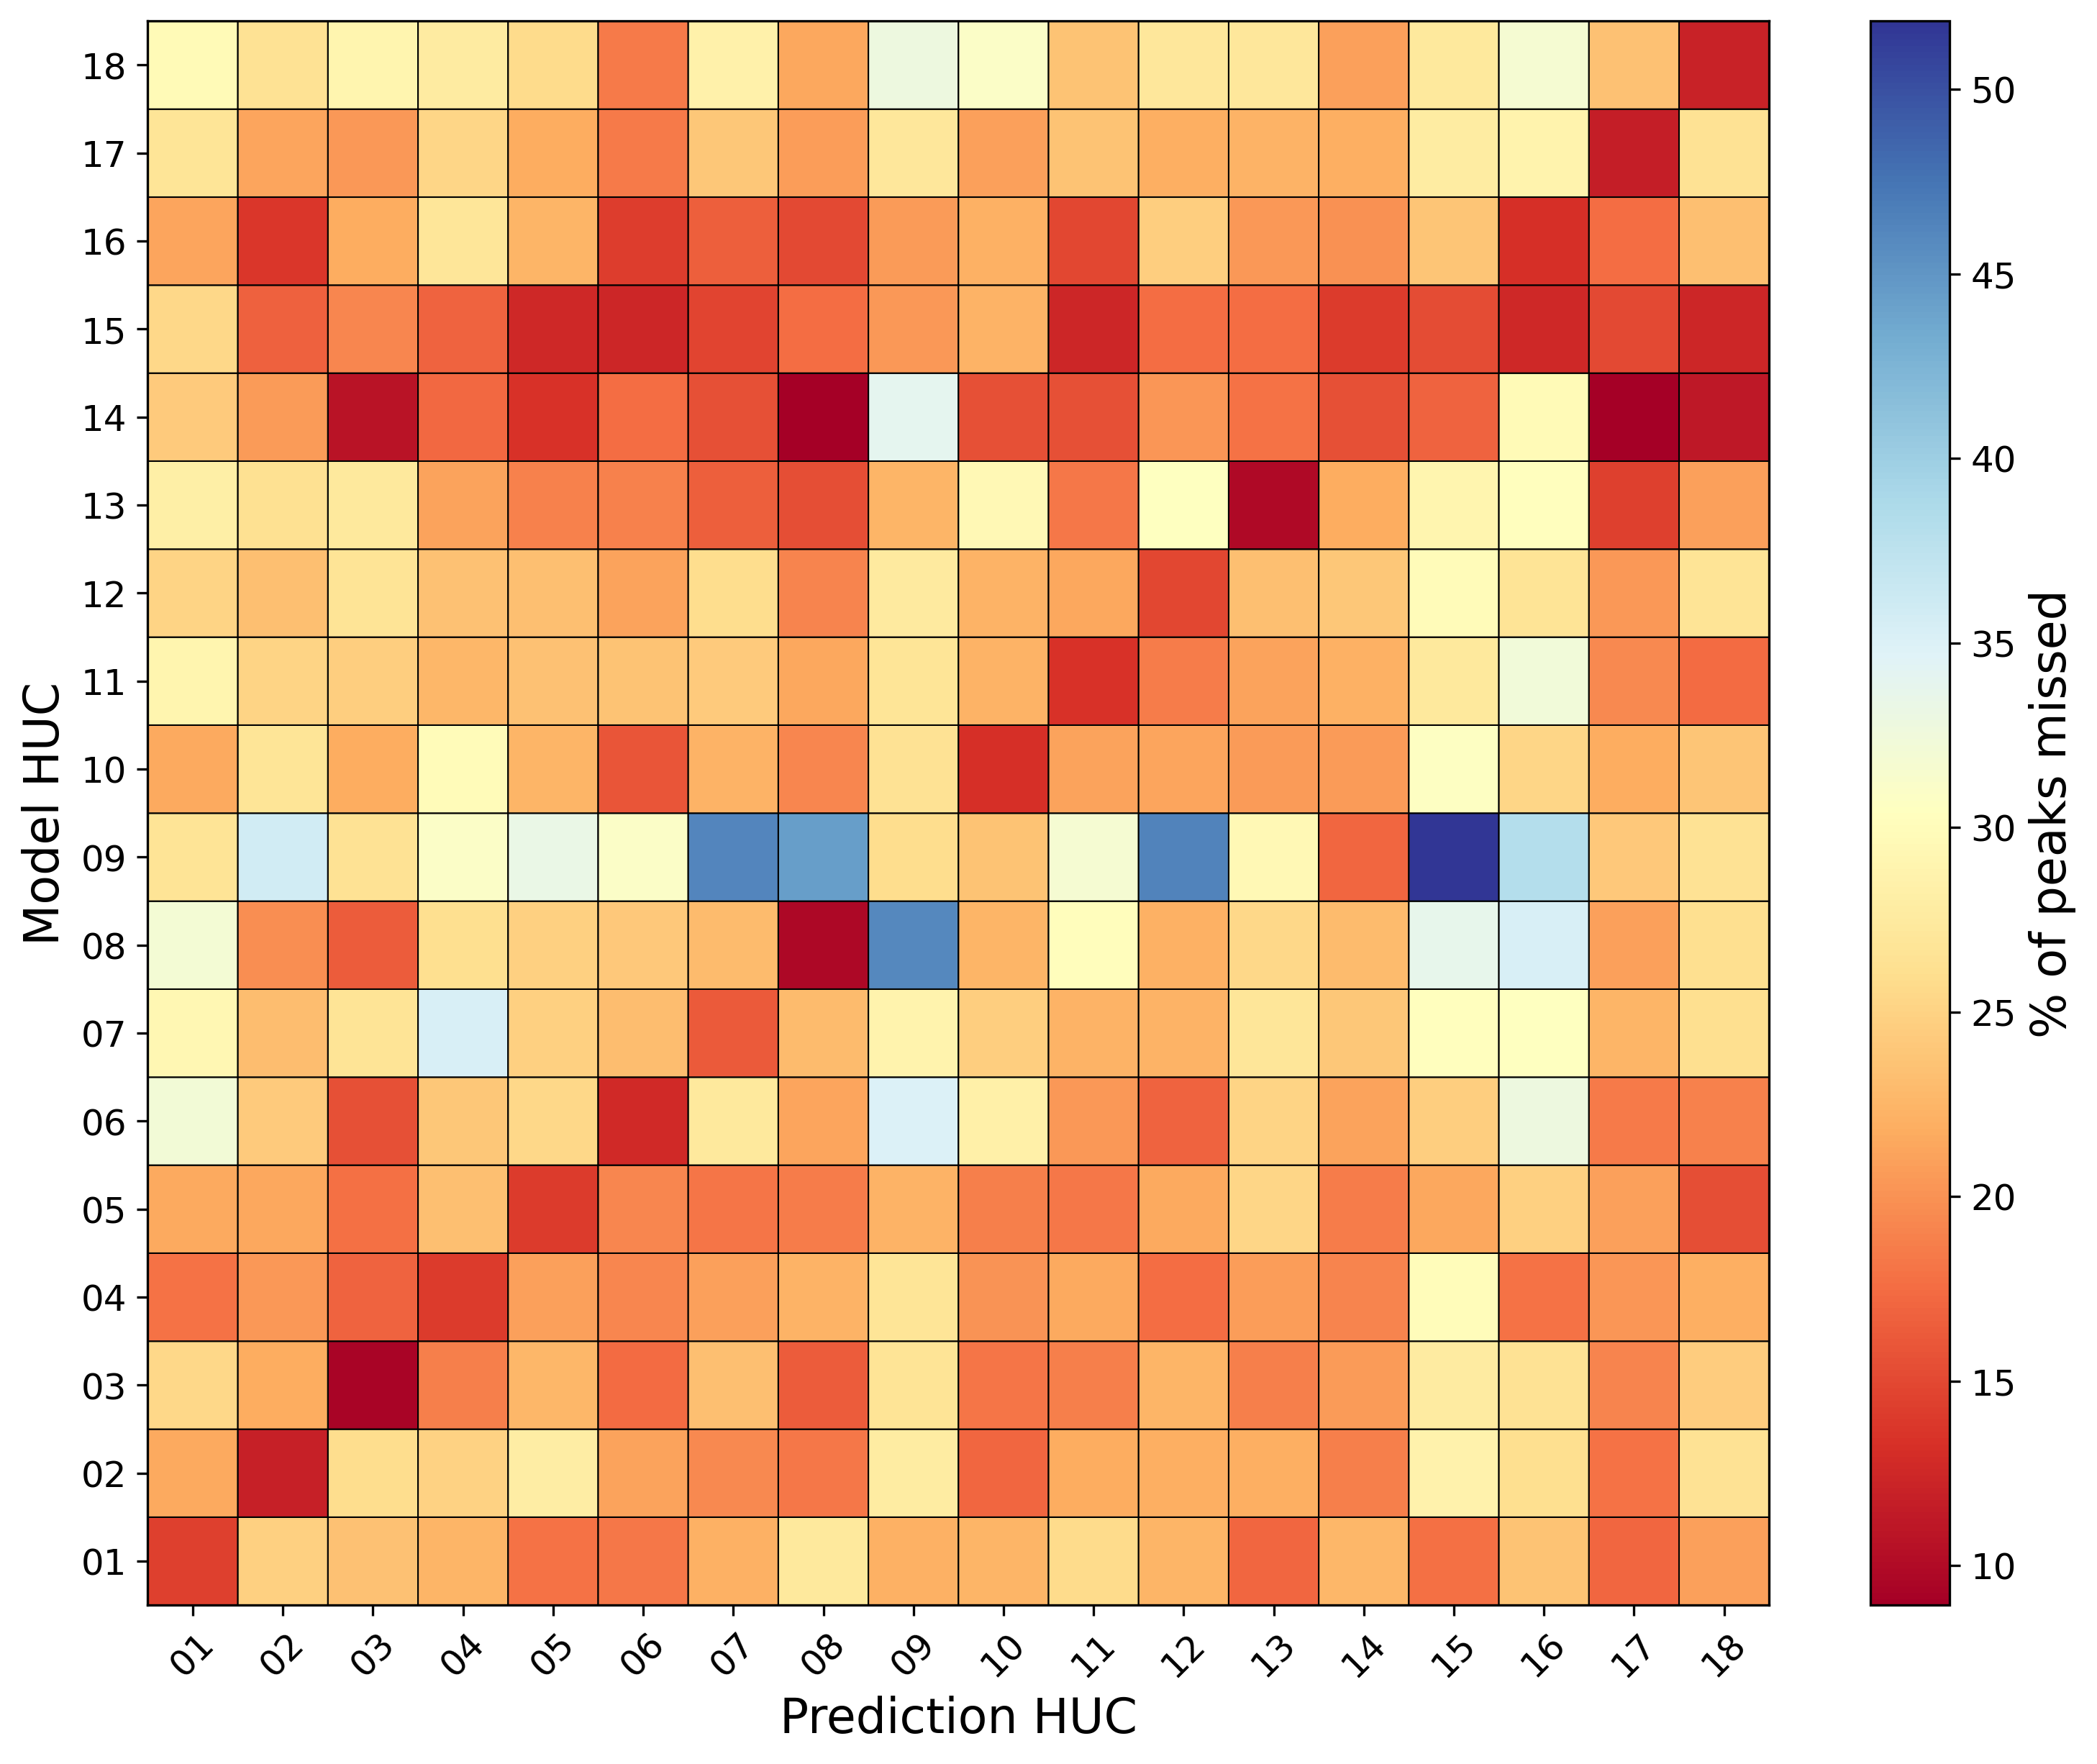

In [54]:
_ = plot_heatmap('missed_peaks', suffix='pred_glofas', lead_time=0, cmap = 'RdYlBu', min_max = None, extend = None, varlabel = '% of peaks missed')

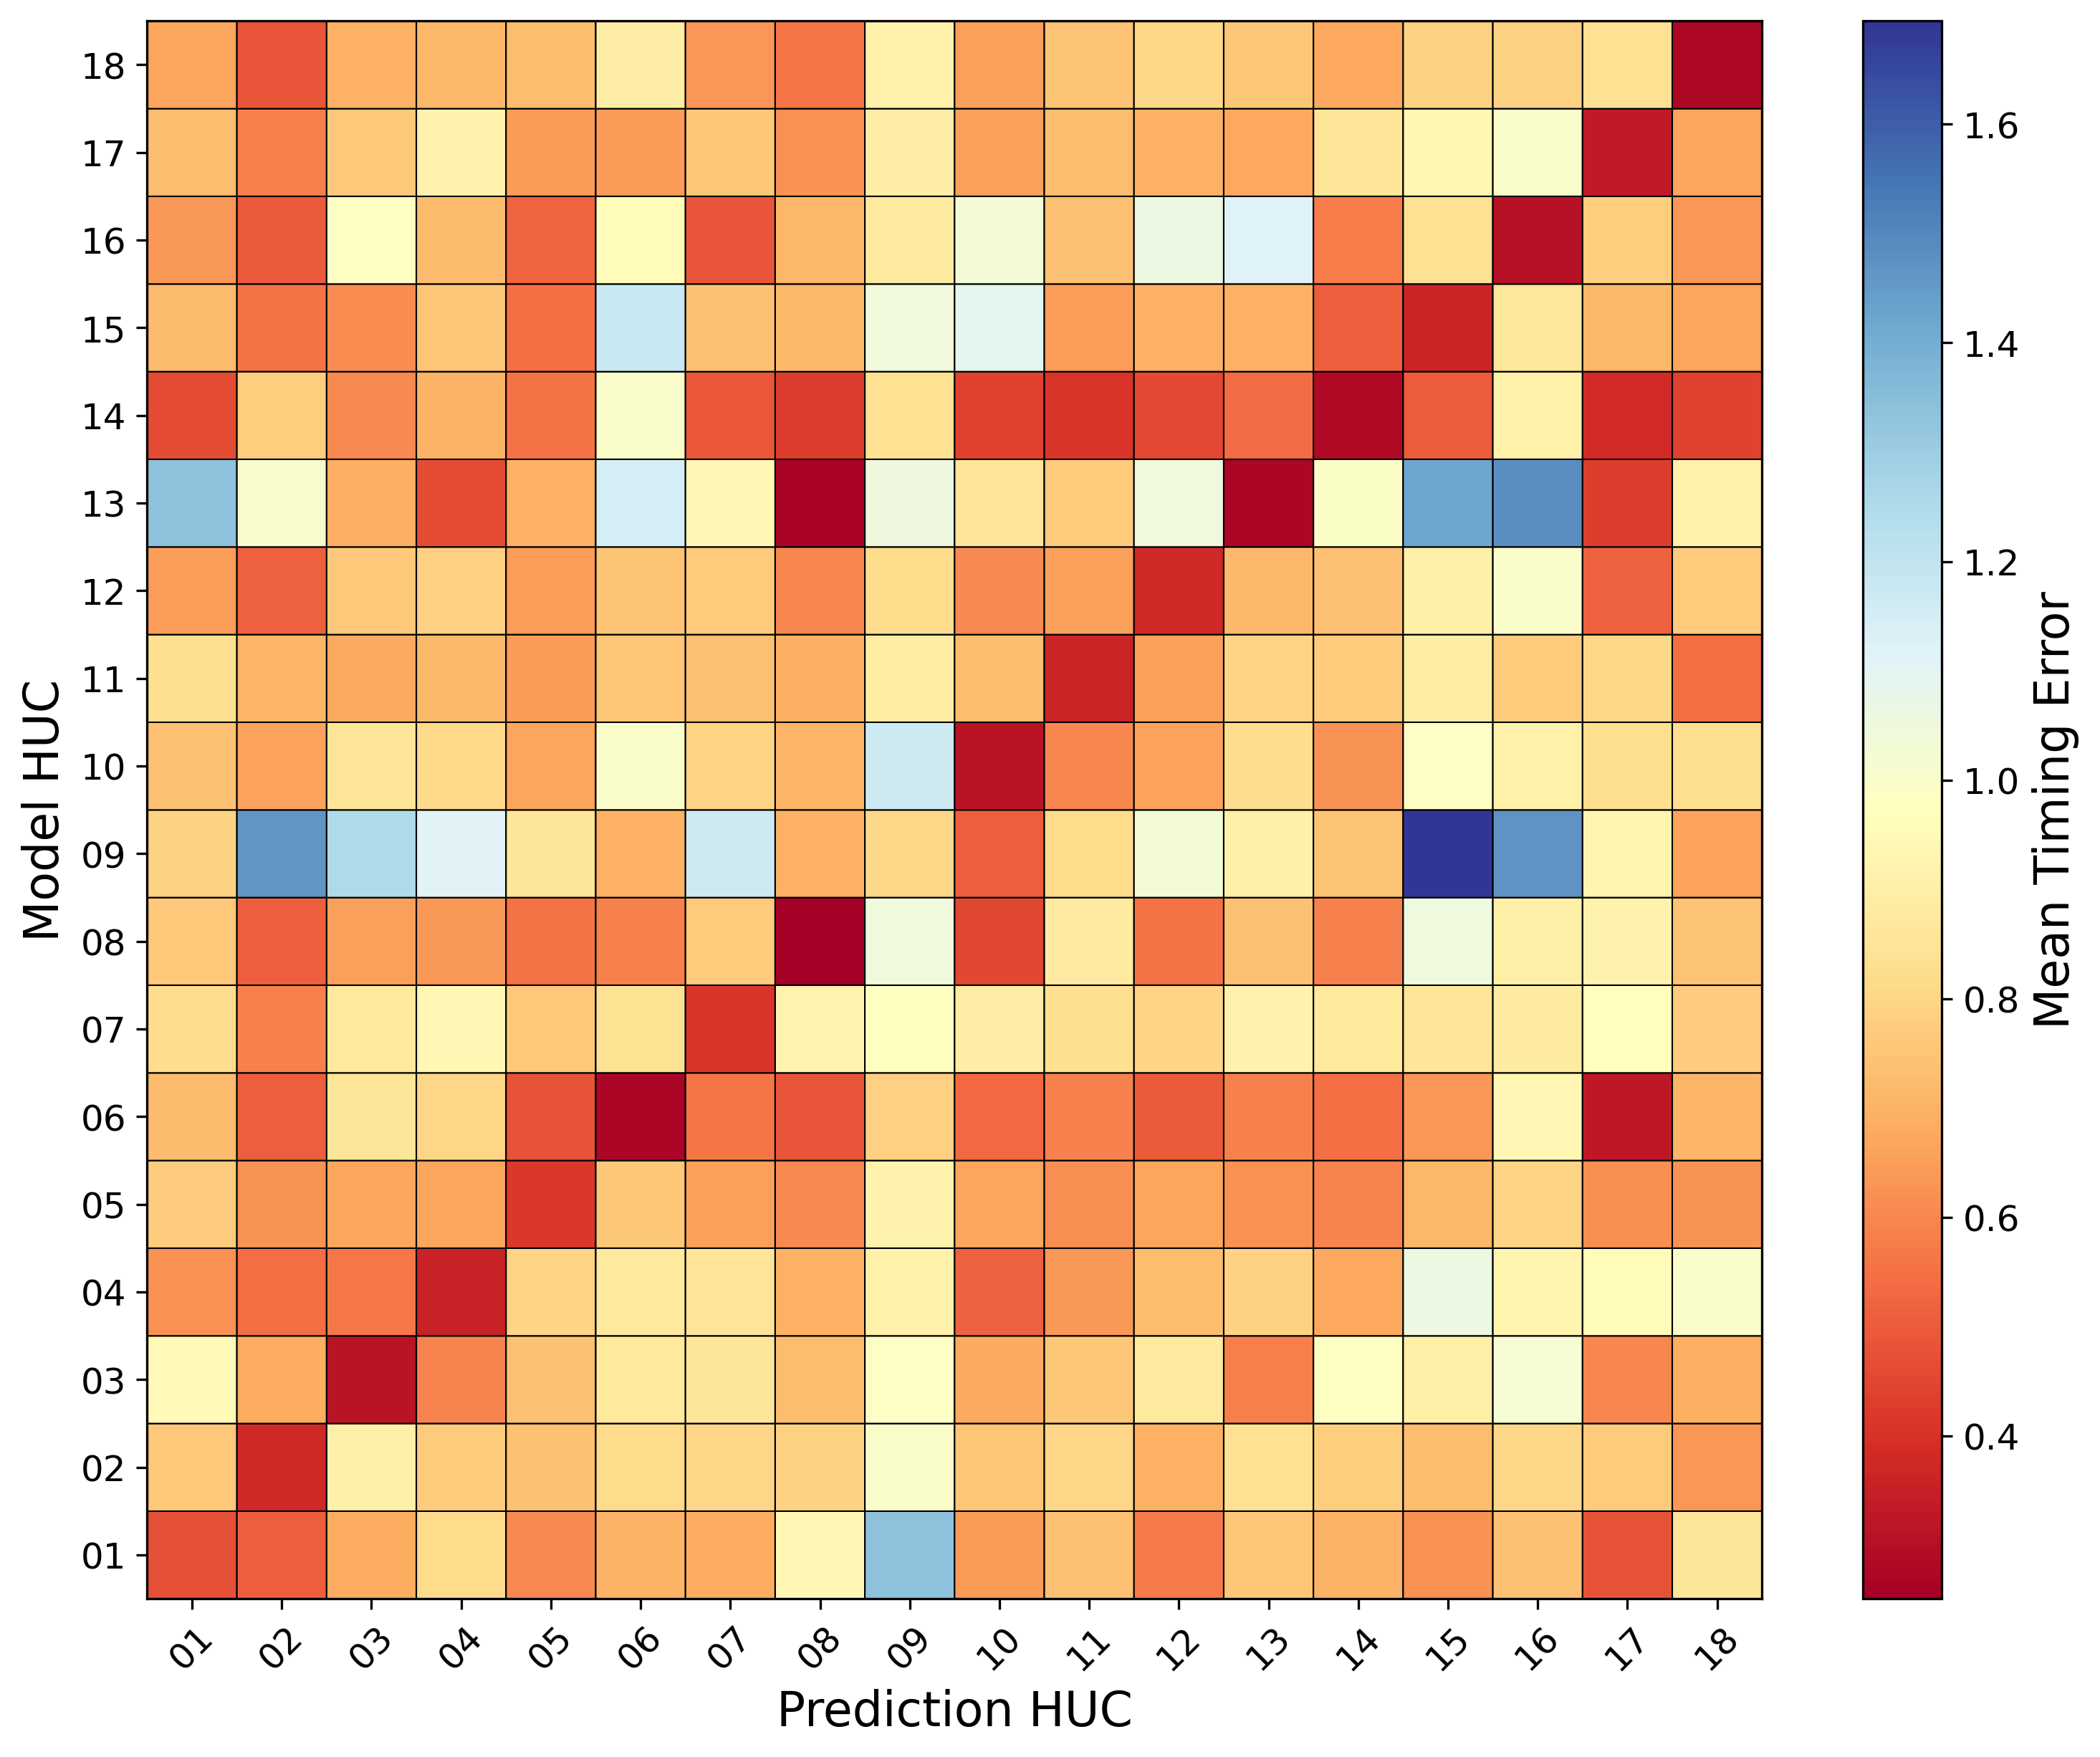

In [55]:
_ = plot_heatmap('mean_peak_timing', suffix='pred_glofas', lead_time=0, cmap = 'RdYlBu', min_max = None, extend = None, varlabel = 'Mean Timing Error')

In [56]:
# _ = plot_heatmap('NSE', suffix='pred_glofas', lead_time=1, cmap = 'RdYlBu', min_max = [-1, 1])

In [ ]:
# _ = plot_heatmap('F1 score of peaks captured', suffix='pred_glofas', lead_time=1, cmap = 'RdYlBu')#, min_max = [0, 1])